# Importing necessary packages

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# Generating data 


## Function to be fitted

In [24]:
def function(x):
  y1 = np.sin(.5*x)
  y2 = np.cos(.8*x)
  y3 = np.tanh(.8*x)
  #y =1e3*((y1 + y2 + y3)*y1+.001*x**2+1e-4*x)
  y = 1e3*(0.01*x**2+np.sin(x*np.sin(.5*x)))
  return y
vf = np.vectorize(function)

### Plot the function

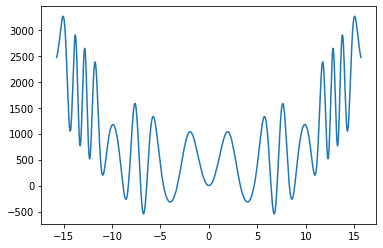

In [26]:
init = -5*np.pi
endval = 5*np.pi
step = .0004
x = np.arange(init,endval+step,step)
y = vf(x) + .1*np.random.rand(np.size(x))
plt.plot(x,y)

## Randomizing and divinding data into test and train sets

In [28]:
p = np.random.permutation(len(x)) # Create a random permutation 
x_perm = x[p]
y_perm = y[p] # Aplling same permutation on both

### Plotting to see if nothing changed (sceptical people go :D )

In [30]:
#plt.plot(x,y)
#plt.plot(x_perm,y_perm,',r')

### Train set and test set, train set is 80% of the data

In [32]:
x_train_full , x_test , y_train_full, y_test = x_perm[:int(np.floor(.8*len(x)))], x_perm[int(np.floor(.8*len(x))):], y_perm[:int(np.floor(.8*len(x)))], y_perm[int(np.floor(.8*len(x))):]

#### Since all the training data is mixed the plot is the same (except for the blank spots)

In [34]:
#plt.plot(x_train_full,y_train_full,',r')

In [36]:
#plt.plot(x_test,y_test,',b')

### Validation and training set

In [38]:
x_train, x_valid, y_train, y_valid = x_train_full[:int(np.floor(.8*len(x_train_full)))], x_train_full[int(np.floor(.8*len(x_train_full))):], y_train_full[:int(np.floor(.8*len(x_train_full)))], y_train_full[int(np.floor(.8*len(x_train_full))):]

In [40]:
#plt.plot(x_train,y_train,',r')

# Scaling the data

In [42]:
scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()
x_train = scaler_in.fit_transform(x_train.reshape(-1,1)).reshape(-1)# fit minMax scaler and scale, reshape to go to a 2D array and reshape it back to 1D
y_train = scaler_out.fit_transform(y_train.reshape(-1,1)).reshape(-1)
x_valid = scaler_in.transform(x_valid.reshape(-1,1)).reshape(-1) # scale
y_valid = scaler_out.transform(y_valid.reshape(-1,1)).reshape(-1)
#### Scaling test data
x_test = scaler_in.transform(x_test.reshape(-1,1)).reshape(-1)
y_test = scaler_out.transform(y_test.reshape(-1,1)).reshape(-1)


# Making the DNN 

#### Using keras functional api to construct the the  problem
#### Using wide and deep neural net

In [44]:
input_ = keras.layers.Input(shape=(1,))
hidden_y = keras.layers.Dense(20, activation="tanh")(input_)
nn_layers = 6
for e_layer in range (nn_layers):
    hidden_x = keras.layers.Dense(20, activation="tanh")(hidden_y)
    #hidden_x = keras.layers.Dropout(rate=0.1)(hidden_x)
    n_layers = 3
    for layer in range(n_layers):
        hidden_x = keras.layers.Dense(10, activation="tanh")(hidden_x)
        #hidden_x = keras.layers.Dropout(rate=0.1)(hidden_x)
    concat = keras.layers.Concatenate()([hidden_y,hidden_x])
    hidden_y = keras.layers.Dense(30, activation="tanh")(concat)
hidden_out_2 = keras.layers.Dense(10, activation="tanh")(hidden_y)
output = keras.layers.Dense(1)(hidden_out_2)
model = keras.Model(inputs=[input_], outputs=[output])

## Compiling the DNN

In [46]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.7, patience=5, verbose=1, min_lr=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
model.compile(loss="mse", optimizer=keras.optimizers.Nadam(lr=0.001))

## Seeing the DNN 

In [43]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 20)           40          input_2[0][0]                    
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 20)           420         dense_33[0][0]                   
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 10)           210         dense_34[0][0]                   
____________________________________________________________________________________________

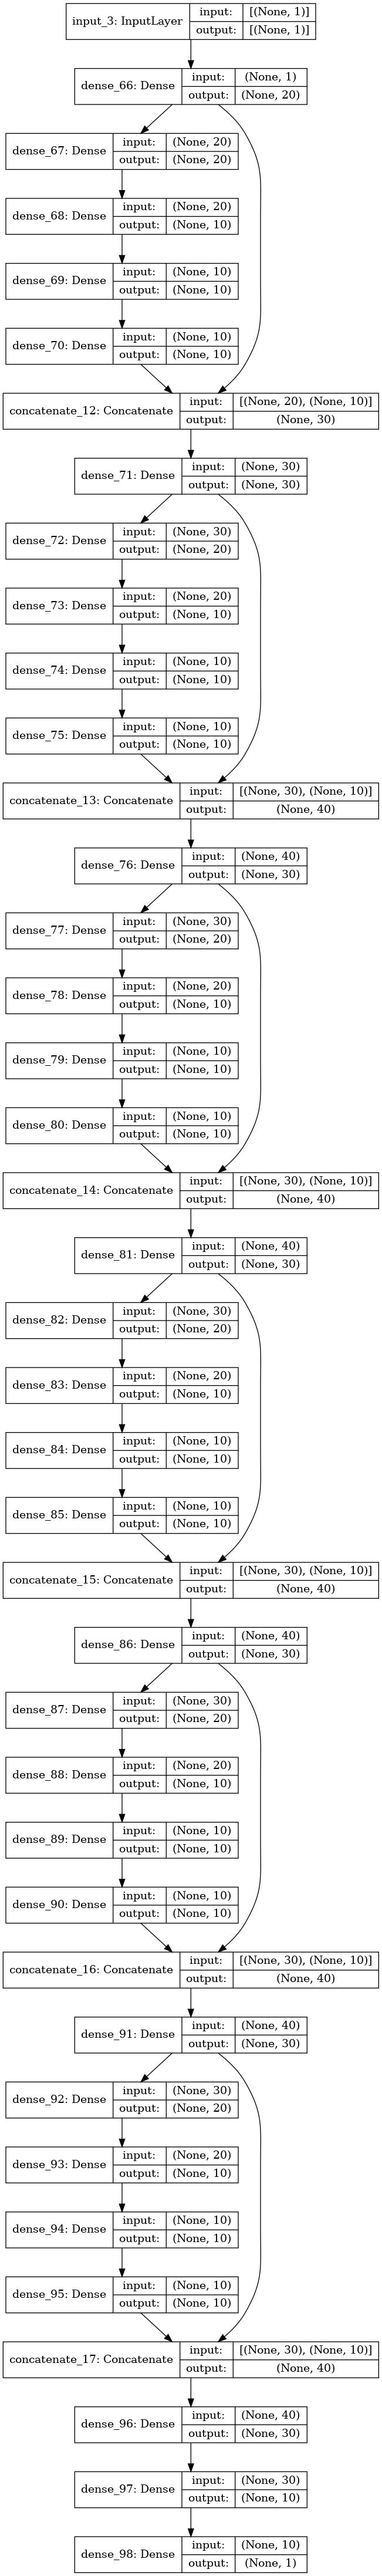

In [45]:
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Fitting the DNN

In [16]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
  with tf.device(device_name):
    history = model.fit(x_train,y_train, epochs=30, validation_data=(x_valid,y_valid))
else:
  history = model.fit(x_train,y_train, epochs=30, validation_data=(x_valid,y_valid),callbacks=[lr_scheduler,early_stop])

Epoch 1/30
1571/1571 [==============================] - 6s 2ms/step - loss: 0.0346 - val_loss: 0.0269
Epoch 2/30
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0251 - val_loss: 0.0254
Epoch 3/30
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0243 - val_loss: 0.0230
Epoch 4/30
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0241 - val_loss: 0.0216
Epoch 5/30
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0224 - val_loss: 0.0217
Epoch 6/30
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0207 - val_loss: 0.0193
Epoch 7/30
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0197 - val_loss: 0.0191
Epoch 8/30
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0197 - val_loss: 0.0203
Epoch 9/30
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0204 - val_loss: 0.0172
Epoch 10/30
1571/1571 [==============================] - 3s 2ms/step - loss: 0.017

In [17]:
mse_test = model.evaluate(x_test, y_test)

491/491 [==============================] - 0s 594us/step - loss: 4.6796e-05


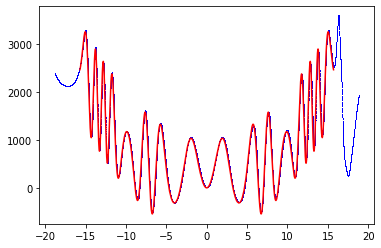

In [18]:
x_new_unscaled = np.arange(-6*np.pi,6*np.pi+step*10,step*10)
x_new = scaler_in.transform(x_new_unscaled.reshape(-1,1)).reshape(-1) # scale data to predict with the same transformation
y_new = model.predict(x_new) # make prediction
y_new_unscaled = scaler_out.inverse_transform(y_new.reshape(-1,1)).reshape(-1) # back to the original scale
plt.plot(x_new_unscaled,y_new_unscaled,',b')
plt.plot(x,y,'r')